# **Simulazioni Metropolis Monte Carlo con il modulo CMS**

### Introduzione: perché il Metropolis Monte Carlo?

Perché vogliamo le _ensamble averages_ ma non è possibile calcolare $6N$ (3 posizione + 3 momento per ciascun atomo) integrali analiticamente. Altre opzioni sarebbero:
- integrazione numerica, ma ancora intrattabile
- MD _time average_ (ergodicità), ma solo per tempi brevi ($<10\ \mu\text{s}$), quindi poco efficace per gli eventi rari (diffusione)
- KMC _time average_, può funzionare, ma condizionato alla scelta dei rate di transizione
- _sampling_ aleatorio dello spazio delle fasi, impossibile sapere se hai collezionato una statistica sufficiente con un numero finito di _sample_ 

---

## Teoria: come funziona il Metropolis Monte Carlo?

### Spazio delle fasi discreto

Media ensemble canonico discreto. Se $x_i$ indica la configurazione (microstato, ma non singolo stato atomico) con energia $E_i$ e su cui $A$ ha valore $A_i$:

$$
\langle A \rangle_{(N,V,T)} = 
\frac{\sum_i A_i e^{-\frac{E_i}{k_B T}}} 
{\sum_ie^{-\frac{E_i}{k_B T}}}
\quad
\text{dove}
\quad
\frac{e^{-\frac{E_i}{k_B T}}} 
{\sum_ie^{-\frac{E_i}{k_B T}}} \equiv P^\text{eq}(x_i)
\quad
\text{e}
\quad 
Z := {\sum_ie^{-\frac{E_i}{k_B T}}}
$$

Poiché più microstati possono dare luogo alla stessa energia, se $\Omega_j$ è il numero di stati con energia $E_j$: $P^\text{eq}(E_j) = \frac{1}{Z} \Omega_j e^{-\frac{E_j}{k_B T}}$


E posso usare $S_j=k_B \ln \Omega_j$, quindi $\Omega_j = e^\frac{S_j}{k_B}$ per riscrivere: 
$$
P^\text{eq}(E_j) = \frac{1}{Z} e^{-\frac{E_j - S_j T}{k_B T}}
\quad
\text{con}
\quad 
F_j = E_j - S_j T 
\quad
\text{energia libera di }\textbf{Helmoltz}
$$

### Importance sampling

Quello che faremo noi è _importance sampling_, cioè costruire i microstati secondo la loro probabilità di comparsa, quindi calcolare il valore di una grandezza fisica su quello stato e valutarne l'importanza tra tutti i possibili stati con la frequenza relativa con cui compare:
$$
\langle A \rangle_{(N,V,T)} \approx \frac1N \sum^{\star}_{j} A_j 
$$
dove la stella sta proprio a indicare che il numero di configurazioni è arbitrario, ma la loro proporzione nel totale rispecchia la statistica discussa in precedenza. 

Ci serve pertanto un metodo per saltare da una configurazione ad un'altra, capace di generare stati distribuiti come richiesto (Boltzmann $P^\text{eq}(x_i) \approx e^{-\frac{E_i}{k_B T}}$).

## Configurational (Metropolis) Monte Carlo

Il _detailed balance_ prescrive il rapporto tra i rate di transizione, ma non li definisce. Una possibile scelta è quella della Metropoli Monte Carlo. Affinché avvenga una transizione $x_i \to x_j$, dev'essere:
1. **sel**ezionata fra tutte le possibili mosse
1. **app**rovata in base alla sua significatività statistica

$$
k_{ji} = P^\text{sel}_{ji} \times P^\text{app}_{ji}
$$

E, come probabilità di accettare la transizione si sceglie:

$$
P^\text{app}_{x_i \to x_j} \equiv
\begin{cases}
1
& se E_j \leq E_i
\\
e^{-\frac{E_j-E_i}{k_B T}}
& se E_j \geq E_i
\end{cases}
$$

quindi sempre accettata se l'energia cala, altrimenti esponenzialmente decrescente con la differenza in energia.

Poiché la mossa da eseguire (_trial move_) è scelta casualmente, si avrà che ogni transizione ha la stessa probabilità di essere selezionata $P^\text{sel}_{ji}=P^\text{sel}_{ij}=\alpha, \forall i,j$

Rimane pertanto (supponendo - senza perdità di generalità, perché è uno o è l'altro - che $E_i < E_j$):
$$
\frac{k_{ji}}{k_{ij}} = e^{-\frac{E_j-E_i}{k_B T}}
$$

Che rispetta il **detailed balance**!

$$P^\text{acc}_{x_i \to x_j} \equiv
\begin{cases}
1
& \text{if}\ E_j \leq E_i
\\
e^{-\frac{E_j-E_i}{k_B T}}
& \text{if}\ E_j \geq E_i
\end{cases}

## Schema algoritmo

Inizialmente, si genera una configurazione casuale depositando in modo aleatorio un certo numero di atomi sulla superficie.

> ⚠️ Poiché la configurazione iniziale è del tutto casuale, il sistema non è all'equilibrio fin da subito, ma lo raggiunge dopo un certo numero di step di **termalizzazione**!

Come anticipato, la mossa da provare (_trial move_) è scelta casualmente da una distribuzione uniforme, per cui si avrà che ogni transizione $x_i \to x_j$ è selezionata con la medesima probabilità $\forall i,j$.

La probabilità di _accettare_ la transizione invece deve descrescere esponenzialmente con l'incremento di energia tra lo stato di partenza e quello di arrivo. L'implementazione prevede semplicemente di generare un numero casuale $\xi\in[0,1)$ e confrontarlo con la probabilità $P^\text{app}_{ji}$

> ⚠️ Le transizioni non rappresentano traiettorie nello spazio. L'algoritmo di MMC non è fatto per simulare l'evoluzione del sistema, non ci sono variabili dipendenti dal tempo!

<img src="../images/7-MetropolisMonteCarlo/MMC-workflow.png" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: auto; width: 500px;">

In questo caso, come avviene anche in [6-KineticMonteCarlo](6-KineticMonteCarlo.ipynb) si applica la logica *solid-on-solid* e si definisce l'energia come:

$$
\varepsilon_k = J_0 + n^{(1)}_{k} J_1
$$
dove $J_0=4J_1$.

---

## Costruire un oggetto `MetropolisMonteCarlo`

L'oggetto [`MetropolisMonteCarlo`](../../CMS/MonteCarlo/MetropolisMonteCarlo.py) di `CMS` contiene la logica dell'algoritmo _configurational Monte Carlo_. Per essere istanzato, richiede i parametri visti nell'introduzione teorica:


<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`L`** | tuple[int, int] | / | Dimensioni x,y della griglia da simulare |
| **`N_atoms`** | int | / | Numero di atomi da posizionare sulla superficie (**SOS**) |
| **`T`** | float | / | Temperatura per la quale si vuole trovare il valore di aspettazione |
| **`J1`** | float | -0.345 | Singola energia di legame in una coppia di vicini |

</div>

Supponiamo di voler indivisuare inizialmente la configurazione più probabile a $T=0K$ che, vista l'assenza del termine di entropia nell'energia libera di Helmoltz, è semplicemente l'energia *minima*. Per farlo, basterà porre la temperatura a $0 \text{ K}$. Prendiamo, in modo del tutto arbitrario una griglia 60x60 e decidiamo di depositarvi 20 atomi. 

In [1]:
from CMS.MonteCarlo.MetropolisMonteCarlo import MetropolisMonteCarlo

griglia = (60,60)
N_atomi = 20
temperatura = 0

simulazione = MetropolisMonteCarlo(
    L=griglia,
    N_atoms=N_atomi,
    T=temperatura
)

Una volta istanziato l'oggetto, l'algoritmo può essere avviato chiamando il metodo `.run()`, che restituirà i risultati raggruppati in un `MetropolisMonteCarloResult`.

<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`N_steps`** | int | 100_000 | Numero totale di step da simulare |
| **`thermalization_steps`** | float | 0 | Numero di step da eliminare dal totale e non considerare nel calcolo |


</div>

In [ ]:
# simuliamo
num_steps = 300_000
steps_termalizzazione = 0
result = simulazione.run(
    N_steps=num_steps,
    thermalization_steps=steps_termalizzazione
)

---

## Esempio di analisi

Un oggetto `MetropolisMonteCarloResult` contiene diversi dati riguardanti la simulazione appena svolta. L'attributo `.energies` contiene tutte le energie del sistema corrispondenti a ciascuna delle `N_steps`configurazioni provate.

Tecnicamente, poiché ci troviamo a $T=0$, il sistema dopo un certo numero di step raggiunge la configurazione di minima energia, da cui spostarsi diventa estremamente improbabile. Ci si aspetta quindi di vedere una prima fase molto disordinata in cui l'energia cala bruscamente (termalizzazione), quindi il sistema raggiunge il suo _equilibrio_ che in questo caso è la ripetizione dello stesso microstato: quello di minima energia. 

### Energia media dell'ensemble a 0 gradi

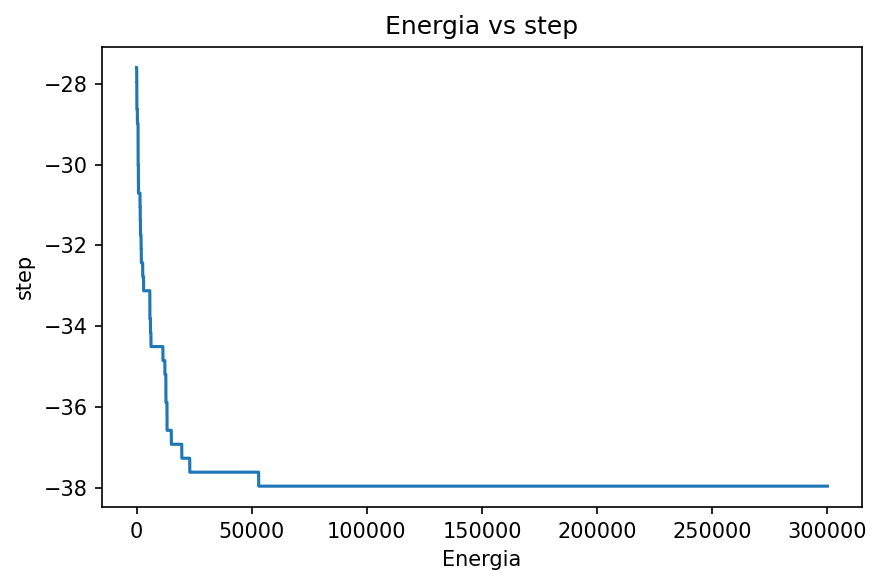

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=150)

x = range(num_steps)
y = result.energies

plt.plot(x,y)
plt.title("Energia vs step")
plt.xlabel("Energia")
plt.ylabel("step")
plt.tight_layout()


Proprio come previsto: l'energia si stabilizza dopo cira 55mila step e rimane costante indefinitamente, poiché a $T=0$ una transizione verso stati più energetici del minimo è infinitamente costosa. Se andiamo a escludere gli step di termalizzazione e calcoliamo la deviazione standard una volta raggiunto l'equilibrio otteniamo:

In [7]:
import numpy as np

energie_a_equilibrio = result.energies[55_000:]
np.std(energie_a_equilibrio)

np.float64(7.105427357601002e-15)

È praticamente nulla! Non è esattamente zero poiché la temperatura non è esattamente 0, ma un numero molto piccolo ($10^{-10}$). Chiaramente si tratta di uno stratagemma necessario per non far esplodere il calcolo numerico.